In [35]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pprint
from custom_library.custom_lib import *

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from collections import defaultdict
from collections import Counter, ChainMap


plt.style.use(style='seaborn')
%matplotlib inline
sns.set()


# Import data set:

In [36]:
pd.options.mode.chained_assignment = None

df_full = import_dataset(encoding='utf-8')
# Convert json to csv:
# df_full.to_csv('../data/dk_asylum_data_1.csv', encoding='utf-8', index=False)
df_full.shape



(9359, 5)

# Dataset preprocessing:

## Keep cases of Unknown Homeland (Ukendt hjemland):

In [37]:
df_UH = df_full[df_full.country == "Ukendt hjemland"]

# Drop redundant column:
df_UH.drop('hasText', axis=1, inplace=True)

# Keep column 'text':
df = df_UH[['text']]

df["text"] = df["text"].astype(str)

df.shape

(192, 1)

In [38]:

df.head()

,text
224,Nævnet stadfæstede i november 2021 Udl...
451,Nævnet stadfæstede i juni 2021 Udlændi...
487,Nævnet stadfæstede i juni 2021 Udlændi...
930,Nævnet stadfæstede i december 2020 Udl...
1320,Nævnet hjemviste i juni 2020 Udlænding...


Check for potential duplicates and drop them:

In [39]:
duplicates_df = df[df.duplicated(['text'], keep=False)]
#pd.concat(g for _, g in df.groupby("text") if len(g) > 1)

# See all duplicates:
duplicates_df

,text
1362,Nævnet stadfæstede i maj 2020 Udlændin...
1381,Nævnet stadfæstede i maj 2020 Udlændin...
4035,Nævnet stadfæstede i januar 2018 Udlæn...
4036,Nævnet stadfæstede i januar 2018 Udlæn...
4090,Nævnet stadfæstede i januar 2018 Udlæn...
4093,Nævnet stadfæstede i januar 2018 Udlæn...


In [40]:
# Drop duplicates from original dataframe:
df = df.drop_duplicates()

# Check shape again:
df.shape

(189, 1)

## Length of texts

Create a numeric column in order to get a feel about the length of the texts. 

In [41]:
df['length'] = df['text'].str.len()

df.describe().T

,count,mean,std,min,25%,50%,75%,max
length,189.0,5008.539683,2046.292952,1104.0,3532.0,4753.0,6057.0,13105.0


## Boxplot:

<AxesSubplot:>

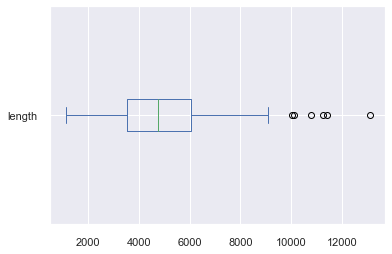

In [42]:
# Box plot:
df['length'].plot(kind='box', vert=False)

## Histogram:

<AxesSubplot:ylabel='Frequency'>

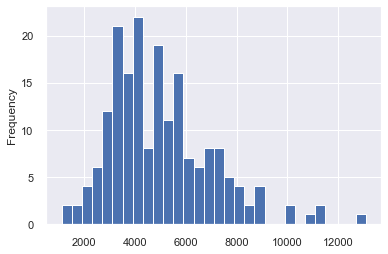

In [43]:
# Histogram:
df['length'].plot(kind='hist', bins=30)


# Create a pipeline:

Steps can be added or removed from the pipeline.

In [44]:
pipeline = [str.lower, remove_punctuation, remove_stopwords, drop_single_letter_words,
            tokenize, lemmatize]


def process(text, pipeline):
    tokens = text
    for transform in pipeline:
        tokens = transform(tokens)
    return tokens


In [45]:
# Apply the process pipeline:
df['tokens'] = df['text'].apply(process, pipeline=pipeline)

# Add column to see the number of tokens:
df['num_tokens'] = df['tokens'].map(len)

In [46]:
df.head()

,text,length,tokens,num_tokens
224,Nævnet stadfæstede i november 2021 Udl...,4753,"[stadfæste, 2021, udlændingestyrels, afgørelse...",333
451,Nævnet stadfæstede i juni 2021 Udlændi...,3149,"[stadfæste, 2021, udlændingestyrels, afgørelse...",225
487,Nævnet stadfæstede i juni 2021 Udlændi...,4433,"[stadfæste, 2021, udlændingestyrels, afgørelse...",324
930,Nævnet stadfæstede i december 2020 Udl...,2664,"[stadfæste, 2020, udlændingestyrels, afgørelse...",187
1320,Nævnet hjemviste i juni 2020 Udlænding...,4626,"[hjemvise, 2020, udlændingestyrels, afgørelse,...",330


# Analysis:

## Quantitative analysis:

## Decision extraction:

In [47]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

df_stad = df['tokens_joined'].str.contains('stadfæste', regex=True)
df_hem = df['tokens_joined'].str.contains('hjemvise', regex=True)
df_med = df['tokens_joined'].str.contains('meddele', regex=True)

# df['decision'] = np.where(df_stad & (df_hem | df_med), "check", np.nan)
df['decision'] = np.where((df_hem | df_med) & df_stad, "denied", np.where(
    df_hem | df_med, "granted", np.where(df_stad, "denied", np.nan)))


Plot decision:

Text(0, 0.5, 'outcomes')

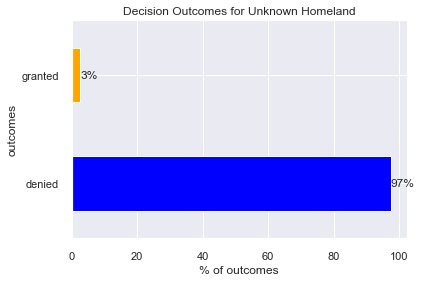

In [48]:
colors = ['blue', 'orange']

# Plot with normalized values:
ax = df['decision'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')
ax.set_xlabel('% of outcomes')
ax.set_ylabel('outcomes')

# Uncomment to plot frequencies:
# ax = df['decision'].value_counts().plot(
#     kind='barh', color=colors, title='Decision Outcomes for Unknown Homeland')
# ax.bar_label(container)


## Year extraction:

In [49]:
df['year'] = df['tokens'].str[1]

Plot decision outcome rate by year:

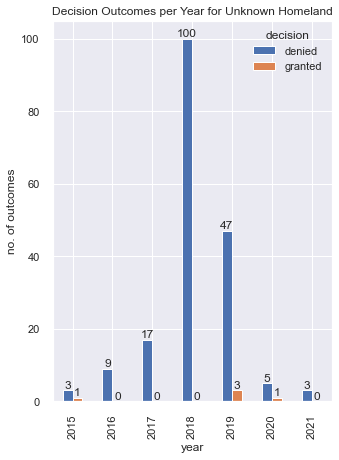

In [50]:
ax = df.groupby(['year'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Year for Unknown Homeland', figsize=(5, 7))
ax.set_xlabel('year')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

## Gender of applicants extraction:

In [51]:
male_pat = 'mandl.*?statsborg.*?|mand.*?ansøg.*?|mand.*?klag.*?'
female_pat = 'kvinde.*?statsborg.*?|kvinde.*?ansøg.*?|kvinde.*?klag.*?'

df_female = df['text'].str.contains(female_pat)
df_male = df['text'].str.contains(male_pat)

df['gender'] = np.where(df_male, "male", np.where(df_female, "female", "unidentified"))

Plot gender distribution:

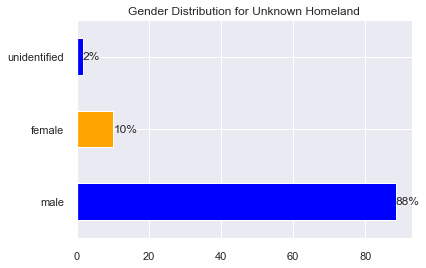

In [52]:
# Plot with normalized values:
ax = df['gender'].value_counts(normalize=True).mul(100).round(1).plot(
    kind='barh', color=colors, title='Gender Distribution for Unknown Homeland')

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f%%')

Plot decision outcome rate by gender:

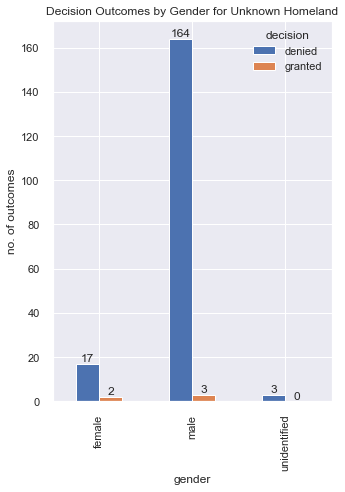

In [53]:
ax = df.groupby(['gender'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes by Gender for Unknown Homeland', figsize=(5, 7))
ax.set_xlabel('gender')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

Plot Decision Outcome Frequencies by Gender for each Year:

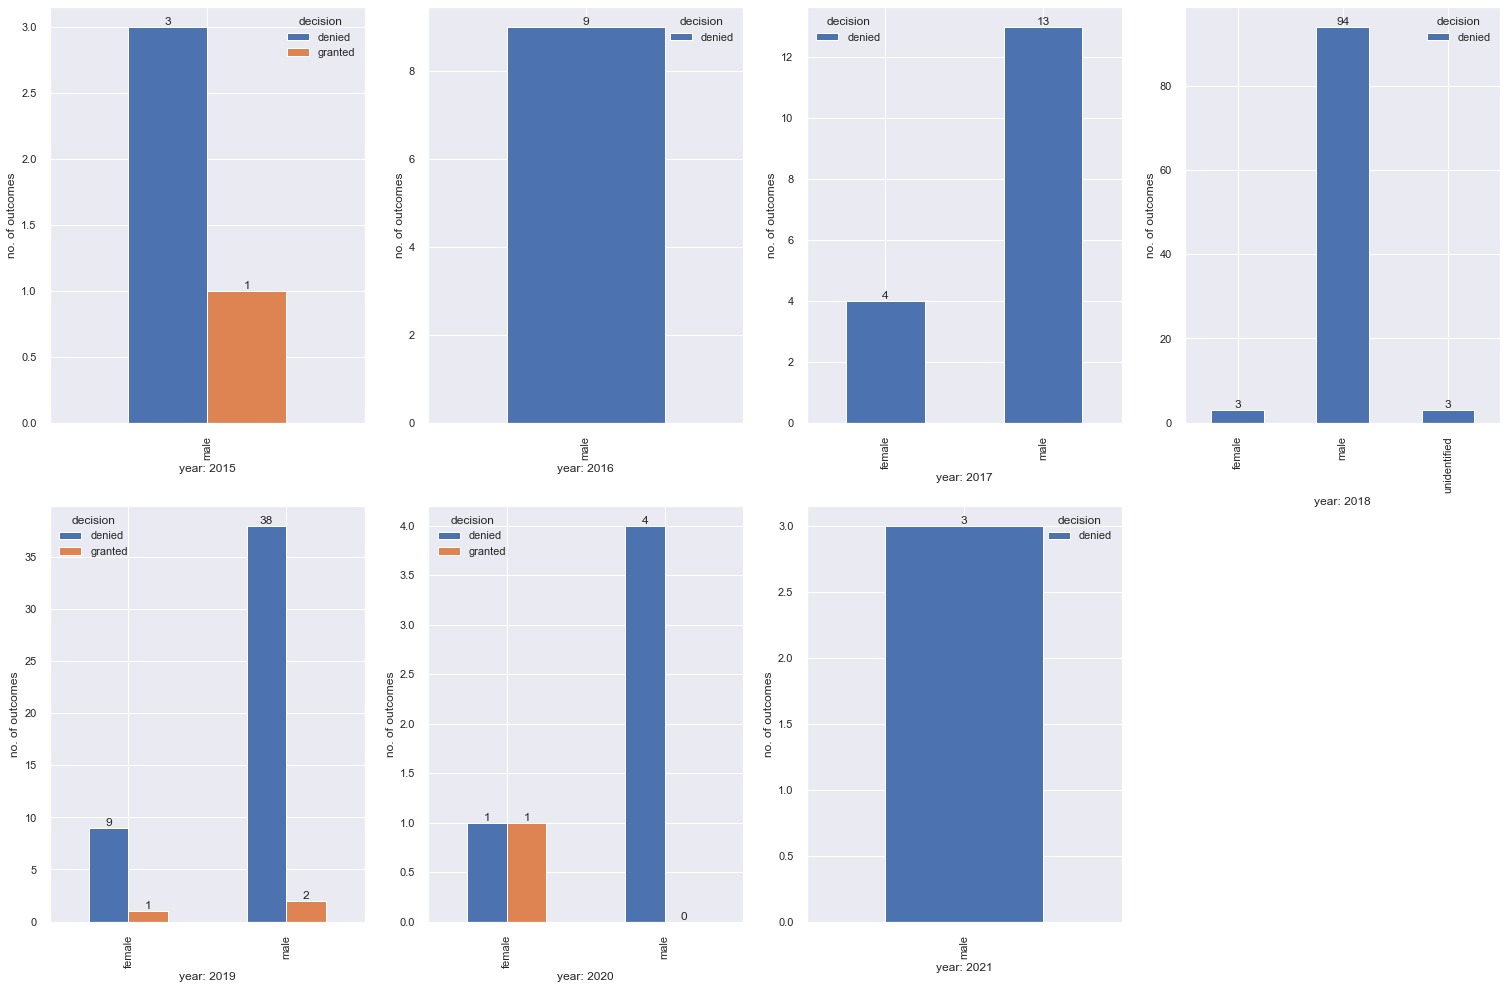

In [54]:
# Uncomment to plot separate figures:
# for year in df['year'].unique():
#     ax = df[df.year==year].groupby(['gender'])['decision'].value_counts().unstack().plot(
#     kind='bar', title='Decision Outcomes by Gender for Unknown Homeland for '+ str(year))
#     ax.set_xlabel('gender')
#     ax.set_ylabel('no. of outcomes')

#     for container in ax.containers:
#         ax.bar_label(container)

# Plot all figures in one:
plt.figure(figsize=(26, 26))
for ix, (key, group) in enumerate(df.groupby('year')):
    ax = plt.subplot(3, 4, ix+1)
    group.groupby('gender')['decision'].value_counts().unstack().plot(kind='bar', ax=ax)
    ax.set_xlabel('year: {}'.format(key))
    ax.set_ylabel('no. of outcomes')
    for container in ax.containers:
        ax.bar_label(container)

## Extract Country of Origin:

In [55]:
syria_pat = 'Syr.*?|damask*?'
irak_pat = 'Irak.*?|irak'
kuwait_pat = 'Kuwait'
eritrea_pat = 'eritr.*?'
algeria_pat = 'alger.*?'
iran_pat = 'Iran.*?'
myanmar_pat = 'minbya|myanmar'
sudan_pat = 'sudan'
somalia_pat = 'somalia'
georgien_pat = 'rusland.*?|tjetjen.*?|georg.*?'
gambia_pat = 'gambia'
afghan_pat = 'kabul|afghan.*?'
sahara_pat = '.*?sahara'
libya_pat = 'tripoli|libyen'
liberia_pat = 'Liberia'
palestine_pat = 'palæstinens.*?'
sierra_pat = 'sierra.*?leone'
etiopia_pat = 'etiopien'

df_syria = df['tokens_joined'].str.contains(syria_pat)
df_irak = df['tokens_joined'].str.contains(irak_pat)
df_kuwait = df['tokens_joined'].str.contains(kuwait_pat)
df_eritrea = df['tokens_joined'].str.contains(eritrea_pat)
df_algeria = df['tokens_joined'].str.contains(algeria_pat)
df_iran = df['tokens_joined'].str.contains(iran_pat)
df_myanmar = df['tokens_joined'].str.contains(myanmar_pat)
df_sudan = df['tokens_joined'].str.contains(sudan_pat)
df_somalia = df['tokens_joined'].str.contains(somalia_pat)
df_georgien = df['tokens_joined'].str.contains(georgien_pat)
df_gambia = df['tokens_joined'].str.contains(gambia_pat)
df_afghan = df['tokens_joined'].str.contains(afghan_pat)
df_sahara = df['tokens_joined'].str.contains(sahara_pat)
df_libya = df['tokens_joined'].str.contains(libya_pat)
df_liberia = df['tokens_joined'].str.contains(liberia_pat)
df_palestine = df['tokens_joined'].str.contains(palestine_pat)
df_sierra = df['tokens_joined'].str.contains(sierra_pat)
df_etiopia = df['tokens_joined'].str.contains(etiopia_pat)

df['origin'] = np.where(df_myanmar, 'myanmar', np.where(df_irak, "irak", 
    np.where(df_kuwait, "kuwait", np.where(df_eritrea, "eritrea", np.where(df_iran, 'iran', 
    np.where(df_algeria, 'algiers', np.where(df_syria, "syria", np.where(df_sudan, 'sudan', 
    np.where(df_somalia, 'somalia', np.where(df_georgien, 'georgien', np.where(df_gambia, 'gambia', 
    np.where(df_afghan, 'afghanistan', np.where(df_sahara, 'sahara', np.where(df_libya, 'libya', 
    np.where(df_liberia, 'liberia', np.where(df_palestine, 'palestine', 
    np.where(df_sierra, 'sierra leone', np.where(df_etiopia, 'etiopia', np.nan))))))))))))))))))
    


Plot distribution of origin:

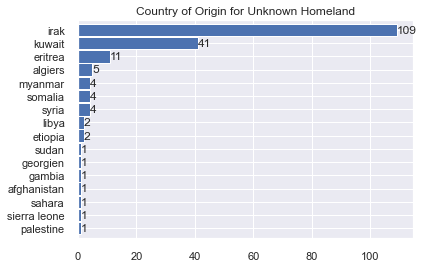

In [72]:
ax = df['origin'].value_counts().plot(
    kind='barh', title='Country of Origin for Unknown Homeland', width=0.95)
ax.invert_yaxis()
for container in ax.containers:
        ax.bar_label(container)

Plot decision outcome rate by origin:

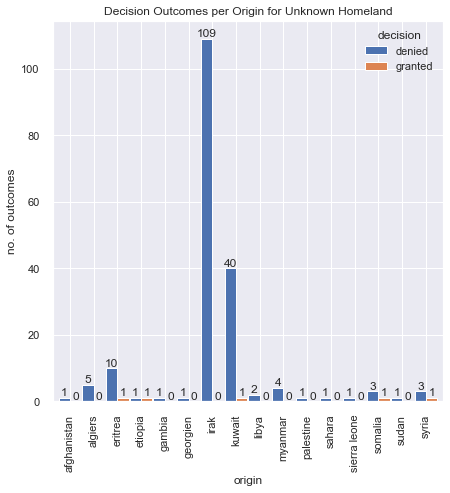

In [73]:
ax = df.groupby(df['origin'])['decision'].value_counts().unstack().plot(
    kind='bar', title='Decision Outcomes per Origin for Unknown Homeland', figsize=(7, 7), width=0.95)
ax.set_xlabel('origin')
ax.set_ylabel('no. of outcomes')

for container in ax.containers:
    ax.bar_label(container)

## Natural Language Processing:

## Frequency analysis:

Here we count the most frequent tokens in the **whole** corpus.


In [58]:
# See ten most frequent words in the whole corpus:
freq_df = count_words(df) 
freq_df.head(10)

# See all words with their frequencies:
# pd.value_counts(np.hstack(df['tokens']))

,freq
token,
ansøger,4307
Kuwait,1370
forklare,1237
oplyse,815
myndighed,795
mandlig,794
asylmotiv,748
forklaring,675
lægge,649


[Text(0.5, 0, 'Frequency'), Text(0, 0.5, 'Token'), Text(0.5, 1.0, 'Top Words')]

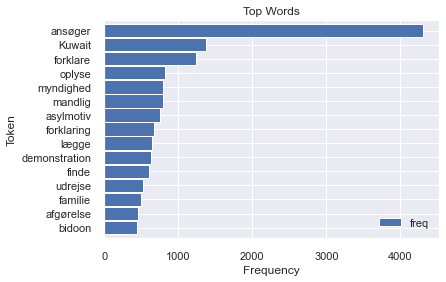

In [59]:
# Plot the results:
ax = freq_df.head(15).plot(kind='barh', width=0.95) 
ax.invert_yaxis()
ax.set(xlabel='Frequency', ylabel='Token', title='Top Words')

## Keyword in context (KWIC):

KWIC analysis produces a list of text fragments of equal length showing the left and right context of a keyword.

Bellow we apply KWIC for `stk` keyword found from the frequency analysis and print 10 random context appearances.

The call is made to the original untokenized & unprocessed dataset.

In [60]:
kwic(df['text'], 'stk', print_samples=10)

10 random samples out of 363 contexts for 'stk':
eller overgreb, omfattet af udlændingelovens § 7,  stk . 1 eller stk. 2. Flygtningenævnet stadfæster derf
ren opholdstilladelse efter udlændingelovens § 7,  stk . 1. Det fremgår af den oprindelige sag, at klager
af udlændingelovens § 19, stk. 2, nr. 1, og § 19,  stk . 7, 1. pkt., jf. § 26, stk. 1, idet styrelsen fin
for opholdstilladelse efter udlændingelovens § 7,  stk . 1 eller stk. 2, er opfyldt. Flygtningenævnet sta
for beskyttelsesstatus, jf. udlændingelovens § 7,  stk . 2. Da det på nuværende tidspunkt må anses som ua
b, omfattet af udlændingelovens § 7, stk. 1 eller  stk . 2. Flygtnin-genævnet stadfæster derfor Udlænding
ladelse efter udlændingelovens § 7, stk. 1, eller  stk . 2, er opfyldt. Flygtningenævnet stadfæster derfo
 bidoonere i Kuwait. Efter udlændingelovens § 40,  stk .1, påhviler det en asylansøger at meddele de oply
 eller overgreb omfattet af udlændingelovens § 7,  stk . 2. Flygtningenævnet stadfæster derfor Udlændin

KWIC for `opholdstilladelse`.

In [61]:
kwic(df['text'], 'opholdstilladelse', print_samples=10)

10 random samples out of 228 contexts for 'opholdstilladelse':
et, og at dette har ført til, at han blev meddelt  opholdstilladelse . Flygtningenævnet har ved vurderingen lagt afgøre
ag, og at dette har ført til, at hun blev meddelt  opholdstilladelse . Flygtningenævnet har ved vurderingen lagt vægt p
åbt sig, ikke kunne føre til, at hun blev meddelt  opholdstilladelse  efter udlændingelovens § 7. Det kan således i hve
. Det følger heraf, at en udlænding, der søger om  opholdstilladelse  efter udlændingelovens § 7, må sandsynliggøre den
ved svig. Betingelserne for at inddrage klagerens  opholdstilladelse  efter udlændingelovens § 19, stk. 2, nr. 1 er her
åledes ikke sandsynliggjort, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7, stk. 1, eller stk. 2,
les asylmotiv ikke kunne føre til, at de meddeles  opholdstilladelse  efter udlændingelovens § 7. Ansøgerne har grundlæ
tiv, og således heller ikke, at betingelserne for  opholdstilladelse  efter udlændingelovens § 7,

## N-gram analysis:

**N-grams** are neighboring sequences of items (words, letters, symbols) in a document. 

Most of the times a probability is assigned to the occurrence of a N-gram (or a word occurring next in a sequence of words). This can help decide which N-grams can be chunked together to form single entities or make predictions for next words (other possible use cases include spelling corrections).  

[Here](https://web.stanford.edu/~jurafsky/slp3/slides/LM_4.pdf), are some slides from Stanford which provide an introduction to N-gram models and the math that goes with it. 

In [62]:
df['tokens_joined'] = [' '.join(token) for token in df['tokens']]

In [63]:
values = defaultdict(int)

# Get the count of every bigram in the data set from last processed column:
for text in df['tokens_joined']:
    for word in generate_N_grams(text, 2):
        values[word] += 1

In [64]:
# Focus on more frequently occuring words.
# Sort in descending order with respect to the column of interest:
df_processed = pd.DataFrame(
    sorted(values.items(), key=lambda x: x[1], reverse=True))

# Ten first values of the first column:
c1 = df_processed[0][:10]
# Ten first values of the second column:
c2 = df_processed[1][:10]


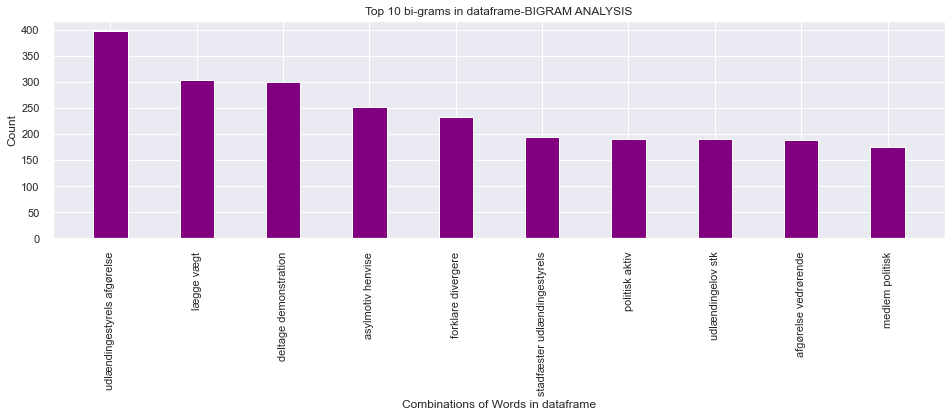

In [65]:
plt.figure(1, figsize=(16, 4))
plt.bar(c1, c2, color='purple',
        width=0.4)
plt.xlabel("Combinations of Words in dataframe")
plt.xticks(rotation=90)
plt.ylabel("Count")
plt.title("Top 10 bi-grams in dataframe-BIGRAM ANALYSIS")
# plt.savefig("dataset-bigram.png")
plt.show()


## TF-IDF

**Term Frequency (TF):**

The number of times a word appears in a document divded by the total number of words in the document. Every document has its own term frequency.

A value close to 1 indicates this term is very important to the document — and primarily composed of it. A low value could mean this term is not very important.

**Inverse Data Frequency (IDF):**

The log of the number of documents divided by the number of documents that contain the word w. Inverse data frequency determines the weight of rare words across all documents in the corpus.

A value close to 0 indicates the term is very common — and not very helpful in differentiating this document from another. A higher value indicates the term is not very common and could be crucial to understanding the theme of this document.

The **TF-IDF** is the multiplication of TF by IDF.

A value close to 0 indicates the term is not important either in the corpus or the document or both. A larger value indicates the term is unique for the document or the corpus or both. This value works best in relation to other terms in the same document, and other documents.

In [66]:
# Get the column of interest:
docs = df['tokens_joined'].tolist()

# Create a vocabulary of words,eliminate stop words if any:

cv = CountVectorizer()
word_count_vector = cv.fit_transform(docs)

# Get shape of resulting vector:
word_count_vector.shape


(189, 4309)

In [67]:
word_count_vector = cv.fit_transform(docs)

# Look at 10 words from our vocabulary:
list(cv.vocabulary_.keys())[:10]


['stadfæste',
 '2021',
 'udlændingestyrels',
 'afgørelse',
 'vedrørende',
 'mandlig',
 'statsborger',
 'ukendt',
 'hjemland',
 'indrejst']

In [68]:
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
tfidf_transformer.fit(word_count_vector)


# Peek at the IDF values:
tfidf_transformer.idf_

array([5.55387689, 5.55387689, 3.11152986, ..., 4.63758616, 5.55387689,
       3.35665231])

In [69]:
# We only need to do this once:
feature_names = cv.get_feature_names_out()

# Generate tf-idf for all documents in list. docs has 192 documents:
tf_idf_vector = tfidf_transformer.transform(cv.transform(docs))

results = []
for i in range(tf_idf_vector.shape[0]):

    # get vector for a single document
    curr_vector = tf_idf_vector[i]

    # sort the tf-idf vector by descending order of scores
    sorted_items = sort_coo(curr_vector.tocoo())   # tocoo() Return a COOrdinate representation of this matrix.

    # extract only the top n; n here is 10
    keywords = extract_top_n_from_vector(feature_names, sorted_items, 10)

    results.append(keywords)

df_tfIDF = pd.DataFrame(zip(docs, results), columns=['doc', 'keywords'])
# df_tfIDF.shape
df_tfIDF


,doc,keywords
0,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'myanmar': 0.392, 'rohingya': 0.293, 'ansøger..."
1,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.417, 'algerium': 0.387, 'frankri..."
2,stadfæste 2021 udlændingestyrels afgørelse ved...,"{'ansøger': 0.378, 'sudan': 0.285, '2020': 0.2..."
3,stadfæste 2020 udlændingestyrels afgørelse ved...,"{'somalia': 0.433, 'alshabaab': 0.417, 'kenya'..."
4,hjemvise 2020 udlændingestyrels afgørelse vedr...,"{'eritreisk': 0.4, 'eritrea': 0.35, 'etiopisk'..."
...,...,...
184,stadfæste 2016 udlændingestyrels afgørelse ved...,"{'fader': 0.499, 'liyu': 0.343, 'police': 0.29..."
185,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'onlf': 0.43, 'ansøger': 0.318, 'police': 0.3..."
186,hjemvise 2015 udlændingestyrels afgørelse vedr...,"{'etiopien': 0.196, 'hjemvise': 0.187, 'foreta..."
187,stadfæste 2015 udlændingestyrels afgørelse ved...,"{'soldat': 0.531, 'ansøger': 0.218, 'burmesisk..."


In [70]:
# Create a dictionary from results list of dictionaries:
my_dict = dict(ChainMap(*results))

c = Counter(my_dict)

# Returns top 20 most common pairs:
most_common = c.most_common(20)

# For getting the keys from `most_common`:
my_keys = [key for key, val in most_common]

# Add pretty printer:
pp = pprint.PrettyPrinter(indent=4)

pp.pprint(most_common)


[   ('klager', 0.81),
    ('officer', 0.622),
    ('taliban', 0.569),
    ('soldat', 0.531),
    ('libyen', 0.508),
    ('police', 0.492),
    ('liyu', 0.492),
    ('tjetjenie', 0.465),
    ('georgien', 0.465),
    ('senegal', 0.464),
    ('sierra', 0.462),
    ('leone', 0.462),
    ('ægtefælle', 0.462),
    ('avis', 0.453),
    ('libysk', 0.443),
    ('hær', 0.436),
    ('holland', 0.436),
    ('somalia', 0.433),
    ('ghanesisk', 0.43),
    ('bøde', 0.426)]


Plot the pairs:

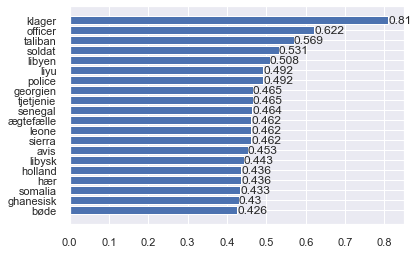

In [71]:
# plt.bar(range(len(most_common)), [val[1] for val in most_common], align='center')
# plt.xticks(range(len(most_common)), [val[0] for val in most_common])
# plt.xticks(rotation=70)

# sort values in tuple:
sorted_most_common = sorted(most_common, key=lambda x: x[1])

fig, ax = plt.subplots()
bars = ax.barh([val[0] for val in sorted_most_common], [val[1] for val in sorted_most_common])

ax.bar_label(bars)
plt.show()